In [7]:
import os
import sys
sys.path.append('../')
from semantic_segmentation import Segmentor
from convert_ckpt_to_pb import model_to_graph
from PIL import Image
import numpy as np
import json

import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import time
from utils.average_meter import FPSMeter

DATA_ROOT = '/media/DATA/UnrealLandingDataset/AirSimCollectData'
IMAGE_ROOT = '/media/DATA/UnrealLandingDataset/AirSimCollectData/image'
LABEL_ROOT = '/media/DATA/UnrealLandingDataset/AirSimCollectData/label'
import matplotlib.pyplot as plt
%matplotlib notebook


class arguments():
    model = 'FCN8sMobileNet'#'FCN8sShuffleNet'#'FCN8sMobileNet'#'UNetMobileNet' #UNetShuffleNet
    mode = 'inference'
    operator = 'Train'
    
    # Directories arguments
    data_dir = "/media/DATA/UnrealLandingDataset/AirSimCollectData/CV_Random_Histogram/" # CV_Random_Histogram/ 
                                                                                         # CV_Manual
                                                                                        # LidarRoofManualTest
    exp_dir =  "fcn8s_mobilenet"#"unet_mobilenet"#"fcn8s_shufflenet"#"fcn8s_mobilenet" # unet_shufflenet
    out_dir = "fcn8s_mobilenet"#"unet_mobilenet"#"fcn8s_shufflenet"#"fcn8s_mobilenet" # unet_shufflenet

    # Data arguments
    img_height = 512
    img_width = 512 
    num_channels = 3
    num_classes = 18
    
    # Train arguments
    num_epochs = 1 
    batch_size = 1
    shuffle = False
    data_mode = "test"
    save_every = 5
    test_every = 5
    max_to_keep = 5
    weighted_loss = False
    random_cropping = False

    # Models arguments
    learning_rate = 0.0001
    weight_decay = 0.0005
    pretrained_path = "../pretrained_weights/mobilenet_v1.pkl"#shufflenet_weights.pkl" #mobilenet_v1.pkl"
    batchnorm_enabled = True
    num_groups = 3
    bias = 0.0
    # Misc arguments
    verbose = False
    
    checkpoint_best_dir = '/home/brianyao/Documents/TFSegmentation/experiments/fcn8s_mobilenet/checkpoints/best'

#     checkpoint_best_dir = '/home/brianyao/Documents/TFSegmentation/experiments/fcn8s_shufflenet/checkpoints/best'
#     checkpoint_best_dir = '/home/brianyao/Documents/TFSegmentation/experiments/unet_mobilenet/checkpoints/best'
#     checkpoint_best_dir = '/home/brianyao/Documents/TFSegmentation/experiments/unet_shufflenet/checkpoints/best'
    summary_dir = 'temp_summary'
args = arguments()

In [8]:
model = Segmentor(args)

Building Test Network...

Building the MODEL...
Building the MobileNet..
Layer_name: network/mobilenet_encoder/conv_1/Relu6 -Output_Shape: [1, 256, 256, 32]
Layer_name: network/mobilenet_encoder/conv_ds_2/pointwise/Relu6 -Output_Shape: [1, 256, 256, 64]
Layer_name: network/mobilenet_encoder/conv_ds_3/pointwise/Relu6 -Output_Shape: [1, 128, 128, 128]
Layer_name: network/mobilenet_encoder/conv_ds_4/pointwise/Relu6 -Output_Shape: [1, 128, 128, 128]
Layer_name: network/mobilenet_encoder/conv_ds_5/pointwise/Relu6 -Output_Shape: [1, 64, 64, 256]
Layer_name: network/mobilenet_encoder/conv_ds_6/pointwise/Relu6 -Output_Shape: [1, 64, 64, 256]
Layer_name: network/mobilenet_encoder/conv_ds_7/pointwise/Relu6 -Output_Shape: [1, 32, 32, 512]
Layer_name: network/mobilenet_encoder/conv_ds_8/pointwise/Relu6 -Output_Shape: [1, 32, 32, 512]
Layer_name: network/mobilenet_encoder/conv_ds_9/pointwise/Relu6 -Output_Shape: [1, 32, 32, 512]
Layer_name: network/mobilenet_encoder/conv_ds_10/pointwise/Relu6 -Outp

In [9]:
'''test on all test data'''
output_records = []
X_batch = np.load(os.path.join(args.data_dir, 'X_val.npy'))
Y_batch = np.load(os.path.join(args.data_dir, 'Y_val.npy'))

In [10]:
nonignore = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
fps_meter = FPSMeter()
elipse = 0
for i in range(X_batch.shape[0]):
    image = X_batch[i:i+1,:,:,:]
    label = Y_batch[i:i+1,:,:]
    start = time.time()
    segmentation = model.run(image, label)
    # update the FPS meter
    fps_meter.update(time.time() - start)

    elipse += time.time() - start
    model.metrics.update_metrics(segmentation[0], label, 0, 0)
    
    # write records
#     curr_record = dict(uid=i,
#                        command='predict_segmentation', 
#                        environment='RTX2080',
#                        building=None,
#                        time=elipse*1000,
#                        metric=None,
#                        misc=None,
#                        tag=None)
#     output_records.append(curr_record)
    
    if i % 100 == 0:
        print(i)
        
iou, mean_iou = model.metrics.compute_final_metrics(1, nonignore)
print("mean_iou: ", mean_iou)
print("iou: ", iou)
print(elipse/(i+1))
# with open(args.model+'.json','w') as f:
#     json.dump(output_records, f, indent=2)

0
100
200
300
400
500
600
700
800
900
1000
mean_iou:  0.7444093589271817
iou:  [0.9939692  0.9306462  0.9627078  0.9784495  0.8209259  0.78980154
 0.4809117  0.7790504  0.4248172  0.79821706 0.7444992  0.
 0.900675   0.8170603 ]
0.010002342554239126


In [9]:
# Unet + MobileNet
mean_iou:  0.7604282030037471
iou:  [0.9974437  0.92528397 0.9699676  0.97778845 0.83257276 0.83868307
 0.49612427 0.80920225 0.4664861  0.8133497  0.77676725 0.
 0.8410272  0.9012985 ]
0.018470920966221736

# Unet + ShuffleNet
% mean_iou:  0.7286985005651202
% iou:  [0.99622333 0.9350349  0.96140844 0.9757877  0.7938346  0.78674895
%  0.3608551  0.7686834  0.33627015 0.7395146  0.7561724  0.
%  0.908519   0.88272643]

0.7444093589271817
[0.9939692  0.9306462  0.9627078  0.9784495  0.8209259  0.78980154
 0.4809117  0.7790504  0.4248172  0.79821706 0.7444992  0.
 0.900675   0.8170603 ]


In [3]:
'''Test single image'''
agent.operator.metrics.reset()
elipse = 0
for i in range(agent.operator.test_data['X'].shape[0]):
    x_batch = agent.operator.test_data['X'][i:i+1,:,:,:]
    y_batch = agent.operator.test_data['Y'][i:i+1,:,:]
    feed_dict = {agent.operator.test_model.x_pl: x_batch,
                 agent.operator.test_model.y_pl: y_batch,
                 agent.operator.test_model.is_training: False
                 }
    
    start = time.time()
    # run the feed_forward
    segmentation = agent.operator.sess.run([agent.operator.test_model.out_argmax],
                                            feed_dict=feed_dict)
    elipse += time.time() - start
    
    segmentation = segmentation[0]
    
    agent.operator.metrics.update_metrics(segmentation, y_batch, 0, 0)
    
    if i % 100 == 0:
        print(i)

iou, mean_iou = agent.operator.metrics.compute_final_metrics(1)

0
100
200
300
400
500
600
700
800
900
1000


In [5]:
print('Dataset: ', args.data_dir)
print('Model: %s \nTime: %2f \nMean_iou: %2f ' %(args.model, 1000*(elipse/i), mean_iou))
print("per class iou:", iou)

Dataset:  /media/DATA/UnrealLandingDataset/AirSimCollectData/CV_Manual/
Model: UNetMobileNet 
Time: 17.204221 
Mean_iou: 0.585809 
per class iou: [0.9954737  0.9062105  0.9517449  0.9709318  0.2903634  0.52976316
 0.35386142 0.57233644 0.47491732 0.30348706 0.7440301  0.5686643
 0.942558   0.8777512  0.         0.09490521 0.38176093]


In [ ]:
# MobileNet FCN8s on Validation dataset
Model: FCN8sMobileNet 
Time: 7.832049 
Mean_iou: 0.764982 
per class iou: [0.9860386  0.93218046 0.9539815  0.97602105 0.9137157  0.8331829
 0.4312528  0.83798105 0.6891968  0.82849056 0.8037586  0.89441836
 0.9196205  0.85471416 0.05385061 0.36721253 0.72908586]

# MobileNet FCN8s on CV_Manual
Model: FCN8sMobileNet 
Time: 8.17
Mean_iou: 0.596185
per class iou: [0.99179333 0.90360403 0.9521174  0.9702189  0.32610297 0.5433829
 0.39259246 0.5730579  0.5097603  0.40318882 0.7335166  0.4484017
 0.9407307  0.8079401  0.00115699 0.1541514  0.48342228]

# MobileNet FCN8s on CV_Random_Histogram
Model: FCN8sMobileNet 
Time: 9.52
Mean_iou: 0.626081
per class iou: [0.9934262  0.9044864  0.9521618  0.9743431  0.7285827  0.79020447
 0.38681448 0.74757016 0.3317044  0.7380395  0.6479621  0.
 0.8933653  0.7890229  0.00248895 0.16101108 0.6021979 ]
    

# ShuffleNet FCN8s on Validation dataset
Model: FCN8sShuffleNet 
Time: 9.939567 
Mean_iou: 0.740697 
per class iou: [0.9819374  0.92100424 0.9454226  0.97071713 0.8919036  0.8143741
 0.4096751  0.8093346  0.65112555 0.7875616  0.7752348  0.8792261
 0.90480435 0.8371956  0.03003817 0.2609902  0.72130483]

# ShuffleNet FCN8s on Manual dataset
Model: FCN8sShuffleNet 
Time: 10.504624 
Mean_iou: 0.567525 
per class iou: [0.9892236  0.8827247  0.94396925 0.9647412  0.3149243  0.5055409
 0.3447977  0.527146   0.45395857 0.33124483 0.71106094 0.48916465
 0.92860883 0.79295146 0.         0.07508529 0.39277738]

# ShuffleNet FCN8s on CV_Random_Histogram dataset
Model: FCN8sShuffleNet 
Time: 9.426008 
Mean_iou: 0.593292 
per class iou: [0.99086666 0.8868926  0.9431177  0.9681425  0.6957779  0.75316083
 0.3502395  0.6926213  0.27422947 0.6553712  0.60759914 0.
 0.8660416  0.7693265  0.0026532  0.08100874 0.5489082 ]
    
# UNetMobileNet on validation dataset
Model: UNetMobileNet 
Time: 16.910503 
Mean_iou: 0.739837 
per class iou: [0.9931862  0.9114253  0.94876796 0.9679644  0.88279146 0.84102774
 0.3548003  0.8069735  0.6990636  0.8250702  0.79234517 0.86773676
 0.92135257 0.8975703  0.         0.25308433 0.61407715]

# UNetMobileNet on CV_Manual dataset
Model: UNetMobileNet 
Time: 17.204221 
Mean_iou: 0.585809 
per class iou: [0.9954737  0.9062105  0.9517449  0.9709318  0.2903634  0.52976316
 0.35386142 0.57233644 0.47491732 0.30348706 0.7440301  0.5686643
 0.942558   0.8777512  0.         0.09490521 0.38176093]
    
# UNetMobileNet on CV_Random_Histogram dataset
Model: UNetMobileNet 
Time: 17.085816 
Mean_iou: 0.601225 
per class iou: [0.9960176  0.8513305  0.9539146  0.9607809  0.6875438  0.8046355
 0.36736372 0.7270763  0.30880427 0.7387913  0.73967934 0.
 0.5588881  0.86241406 0.         0.09831192 0.56527215]

In [18]:
from utils.seg2rgb import *
cmap_list, seg2rgb_map = get_seg2rgb_map('/media/DATA/UnrealLandingDataset/AirSimCollectData/seg_rgbs.txt', 18)

In [21]:
segmentation = segmentation[0]
seg_rgb = np.zeros([segmentation.shape[0], segmentation.shape[1], 3])
all_classes = np.unique(segmentation)
for i in all_classes:
    seg_rgb[np.where(segmentation == i)] = seg2rgb_map[i][:3]

gt_seg_rgb = np.zeros([y_batch[0].shape[0], y_batch[0].shape[1], 3])
all_gt_classes = np.unique(y_batch[0])
for i in all_gt_classes:
    gt_seg_rgb[np.where(y_batch[0] == i)] = seg2rgb_map[i][:3]


<IPython.core.display.Javascript object>


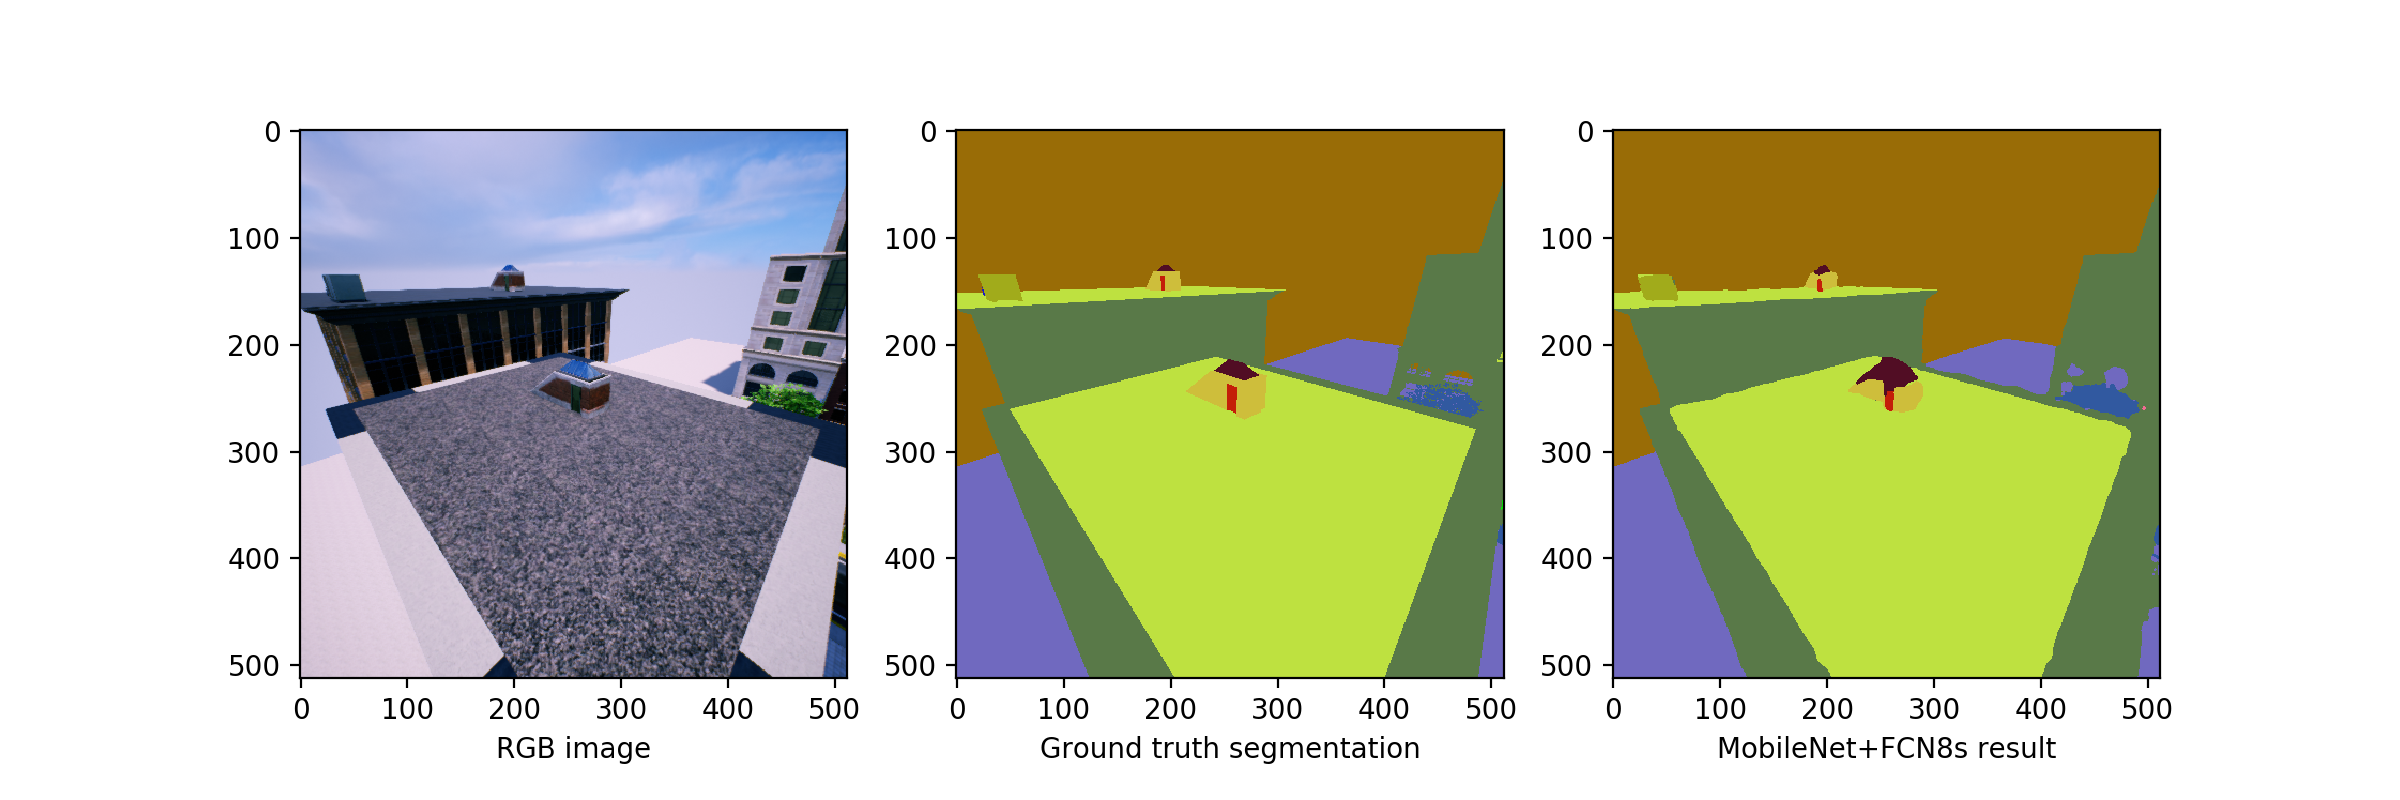

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.imshow(x_batch[0])
ax1.set_xlabel("RGB image")
ax2.imshow(gt_seg_rgb)
ax2.set_xlabel("Ground truth segmentation")
ax3.imshow(seg_rgb)
ax3.set_xlabel("MobileNet+FCN8s result")
plt.savefig("MobileNet_FCN8s_CV_Manual.png")

In [21]:
'''inference on small shot test dataset'''
import os
SMALL_SHOT_DATA_DIR = '/media/DATA/UnrealLandingDataset/LidarRoofTest'
img_np_file = os.path.join(SMALL_SHOT_DATA_DIR,'x_batch.npy')
label_np_file = os.path.join(SMALL_SHOT_DATA_DIR,'y_batch.npy')

x_batch = np.load(img_np_file)
print(x_batch.shape)
y_batch = np.load(label_np_file)
print(x_batch.shape)

all_outputs = []
for i in range(x_batch.shape[0]):
    feed_dict = {agent.operator.test_model.x_pl: x_batch[i:i+1,:,:,:],
                 agent.operator.test_model.y_pl: y_batch[i:i+1,:,:,0],
                 agent.operator.test_model.is_training: False
                 }


    # run the feed_forward
    segmentation = agent.operator.sess.run([agent.operator.test_model.out_argmax],
                                            feed_dict=feed_dict)
    segmentation = segmentation[0]
    all_outputs.append(segmentation)
all_outputs = np.array(all_outputs)

(8, 512, 512, 3)
(8, 512, 512, 3)


In [24]:
np.save('seg_outputs.npy', all_outputs)

<IPython.core.display.Javascript object>


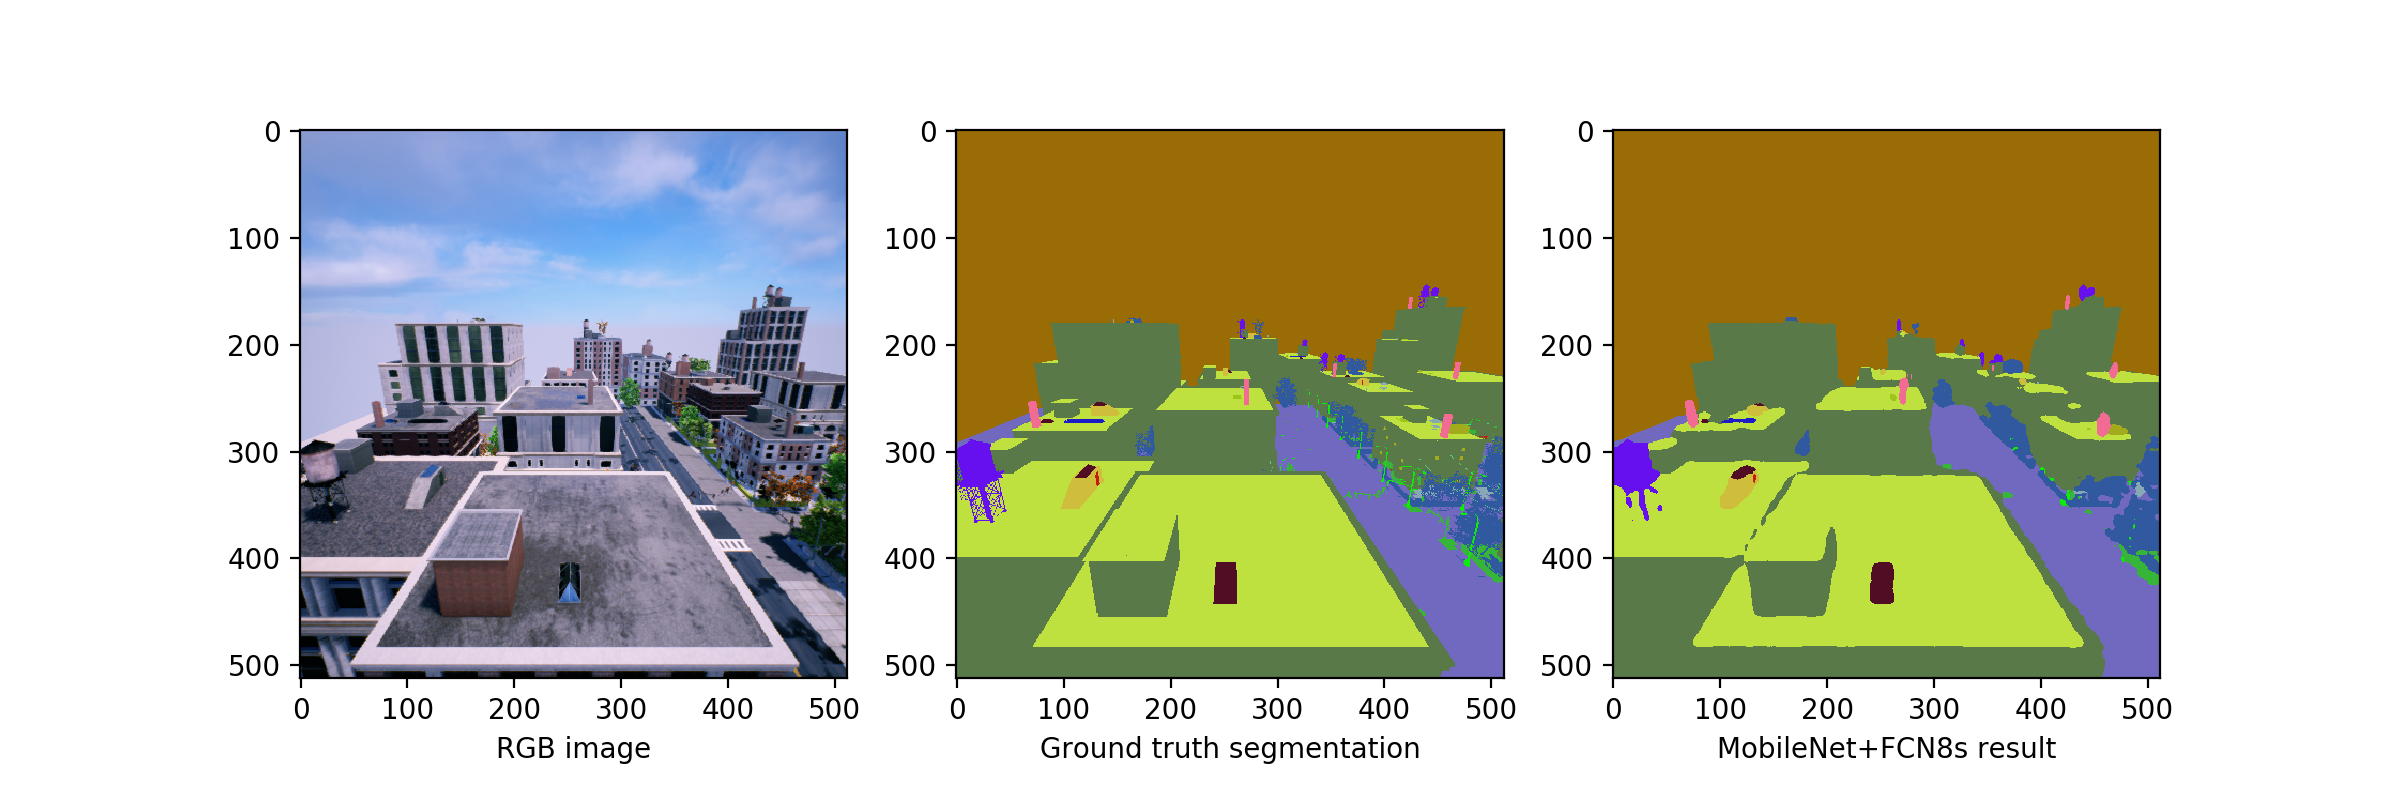

Text(0.5, 0, 'MobileNet+FCN8s result')

In [29]:
segmentation = segmentation.squeeze(0)
seg_rgb = np.zeros([segmentation.shape[0], segmentation.shape[1], 3])
all_classes = np.unique(segmentation)
for i in all_classes:
    seg_rgb[np.where(segmentation == i)] = seg2rgb_map[i][:3]
    
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.imshow(x_batch[-1])
ax1.set_xlabel("RGB image")
ax2.imshow(y_batch[-1])
ax2.set_xlabel("Ground truth segmentation")
ax3.imshow(seg_rgb)
ax3.set_xlabel("MobileNet+FCN8s result")


In [10]:
'''test on real world'''
import os
from PIL import Image

real_img = 'real_roof.png'

x_batch = np.asarray(Image.open(real_img).resize((512,512)).convert('RGB'))
x_batch = np.expand_dims(x_batch, axis=0)
print(x_batch.shape)
y_batch = x_batch[:,:,:,0]

(1, 512, 512, 3)


In [20]:
all_outputs = []
for i in range(x_batch.shape[0]):
    feed_dict = {agent.operator.test_model.x_pl: x_batch,
                 agent.operator.test_model.y_pl: y_batch,
                 agent.operator.test_model.is_training: False
                 }


    # run the feed_forward
    segmentation = agent.operator.sess.run([agent.operator.test_model.out_argmax],
                                            feed_dict=feed_dict)
    segmentation = segmentation[0]
    all_outputs.append(segmentation)
all_outputs = np.array(all_outputs)

<IPython.core.display.Javascript object>


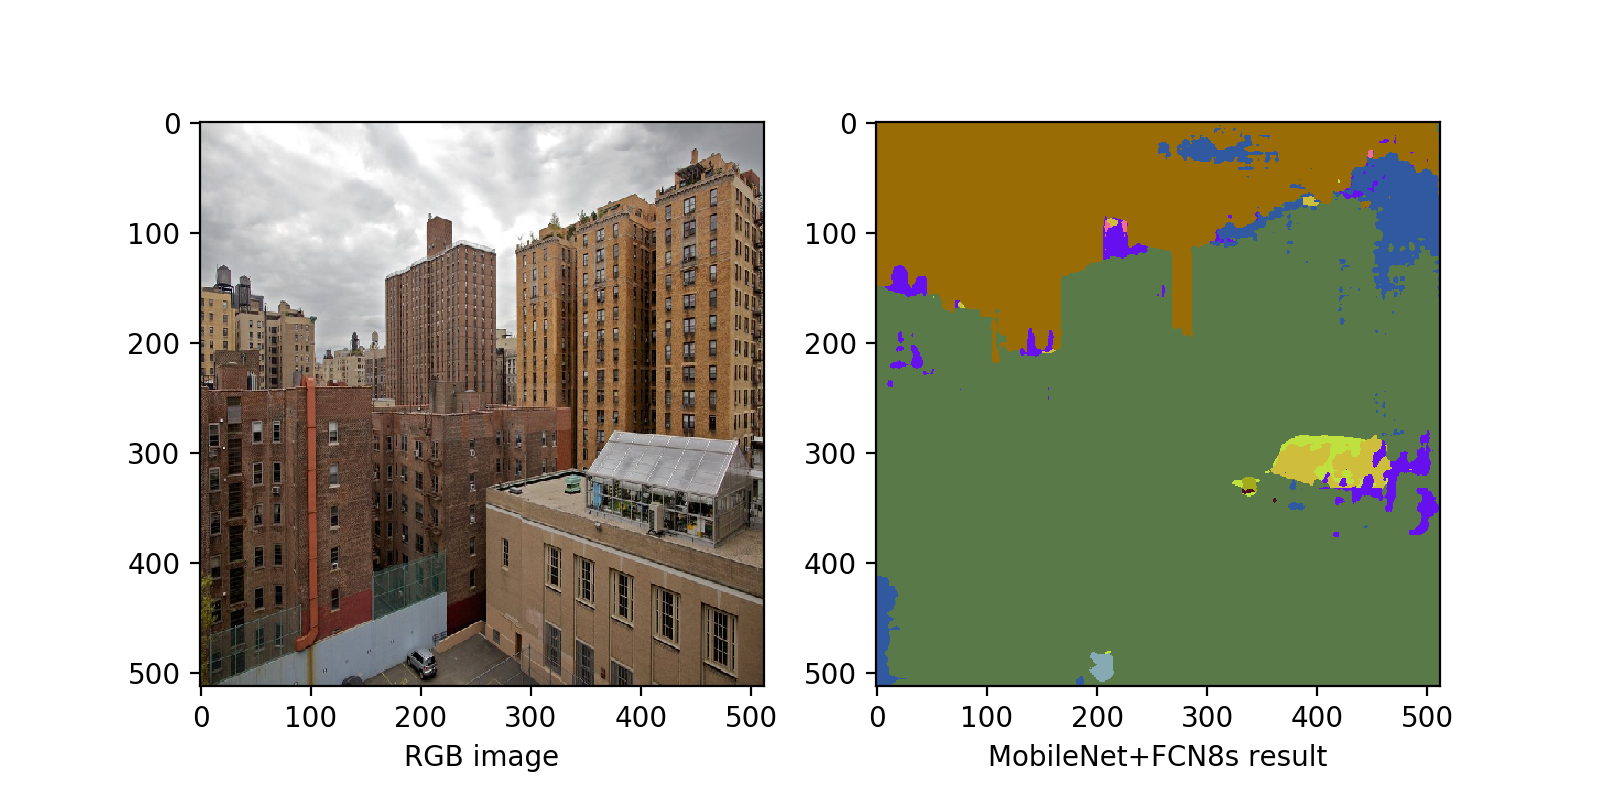

Text(0.5, 0, 'MobileNet+FCN8s result')

In [21]:
segmentation = segmentation.squeeze(0)
seg_rgb = np.zeros([segmentation.shape[0], segmentation.shape[1], 3])
all_classes = np.unique(segmentation)
for i in all_classes:
    seg_rgb[np.where(segmentation == i)] = seg2rgb_map[i][:3]
    
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), nrows=1, ncols=2)
ax1.imshow(x_batch[0])
ax1.set_xlabel("RGB image")
ax2.imshow(seg_rgb)
ax2.set_xlabel("MobileNet+FCN8s result")


In [22]:
plt.savefig('real_roof_seg.png')